# Colab specifc
If we are in a google colab we have to move to the correct directory

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
%cd /content/drive/MyDrive/BATH/Evaluation

/content/drive/MyDrive/BATH/Evaluation


# Calculate different metrices
Before this notebook can be used with the generated answers from medvet we have to add the answers from ChatGPT-4. This answers were generated manually in the ChatGPT interface.
Used Model: ChatGPT 4
Used prompt template: "You are an intelligent assistant designed to support veterinarians by providing detailed and specific responses related to veterinary medicine, including diagnosis and treatment. You analyze the provided case and tailor your answers to the specific species and context of the inquiry.  Follow the instructions carefully and explain your answers in detail. ...."

---------------------------
Used model in MedVet: LlaMA 2 7b-chat with 8bit quantization as .gguf format
used prompt template: "Casesolver"

In [4]:
import pandas as pd

# Read the CSV file
answer_data = pd.read_csv("Results/Evaluation MedVet Cases.csv")

# View the first 5 rows
answer_data.head()

,Number,Case,Image,Solution,Source,Answer MedVet,Answer ChatGPT
0,1,Jake is a 3-year-old neutered German shepherd....,-,Periodontal disease is present to some degree ...,https://angelscampvetgroup.com/pet-dental-heal...,"Ah, I see. Based on the information provided,...","\nBased on the symptoms described for Jake, it..."
1,2,Casey is a 14-year-old spayed domestic shortha...,-,If bacteria aren‚Äôt removed from under a pet‚...,https://angelscampvetgroup.com/pet-dental-heal...,Thank you for providing the details of Casey'...,"Based on the symptoms described for Casey, the..."
2,3,Karl is a 5-year-old neutered greyhound. Karl‚...,-,As periodontal disease progresses to stage thr...,https://angelscampvetgroup.com/pet-dental-heal...,Thank you for providing me with the details of...,The symptoms Karl is experiencing suggest a de...
3,4,Dolly was a 14-year-old spayed female Chihuahu...,-,"When periodontal disease becomes advanced, sev...",https://angelscampvetgroup.com/pet-dental-heal...,Thank you for sharing the details of Dolly's ...,\nDolly's clinical presentation and findings f...
4,5,"A 13-year-old, female Shiba dog presented with...",Image Case 5,"In this case, MCT involved subcutaneous bleedi...",https://bvajournals.onlinelibrary.wiley.com/do...,Based on the provided case description and ac...,The information provided in the case of the 13...


## Calculate cosine similarity

In [5]:
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity

# Load the CSV file
df = pd.read_csv('Results/Evaluation MedVet Cases.csv')

# Initialize the TF-IDF Vectorizer
vectorizer = TfidfVectorizer()

# Combine the text from both columns for vectorization
all_text = pd.concat([df['Solution'], df['Answer MedVet'],df['Answer ChatGPT']], axis=0)

# Fit the vectorizer on all the text
vectorizer.fit(all_text)

# Transform text1 and text2 into TF-IDF vectors
tfidf_text1 = vectorizer.transform(df['Solution'])
tfidf_text2 = vectorizer.transform(df['Answer MedVet'])
tfidf_text3 = vectorizer.transform(df['Answer ChatGPT'])

# Calculate the cosine similarity between each pair of vectors
# cosine_similarity returns a matrix, we take the diagonal where the pair similarities are found.
df['cosine_similarity_medvet'] = [cosine_similarity(tfidf_text1[i], tfidf_text2[i])[0][0] for i in range(len(df))]
df['cosine_similarity_chatgpt'] = [cosine_similarity(tfidf_text1[i], tfidf_text3[i])[0][0] for i in range(len(df))]

# Save the updated DataFrame back to CSV
df.to_csv('Results/Evaluation MedVet Cases combined scores.csv', index=False)

df.head()

,Number,Case,Image,Solution,Source,Answer MedVet,Answer ChatGPT,cosine_similarity_medvet,cosine_similarity_chatgpt
0,1,Jake is a 3-year-old neutered German shepherd....,-,Periodontal disease is present to some degree ...,https://angelscampvetgroup.com/pet-dental-heal...,"Ah, I see. Based on the information provided,...","\nBased on the symptoms described for Jake, it...",0.274826,0.478195
1,2,Casey is a 14-year-old spayed domestic shortha...,-,If bacteria aren‚Äôt removed from under a pet‚...,https://angelscampvetgroup.com/pet-dental-heal...,Thank you for providing the details of Casey'...,"Based on the symptoms described for Casey, the...",0.336539,0.413385
2,3,Karl is a 5-year-old neutered greyhound. Karl‚...,-,As periodontal disease progresses to stage thr...,https://angelscampvetgroup.com/pet-dental-heal...,Thank you for providing me with the details of...,The symptoms Karl is experiencing suggest a de...,0.318073,0.305745
3,4,Dolly was a 14-year-old spayed female Chihuahu...,-,"When periodontal disease becomes advanced, sev...",https://angelscampvetgroup.com/pet-dental-heal...,Thank you for sharing the details of Dolly's ...,\nDolly's clinical presentation and findings f...,0.287016,0.365178
4,5,"A 13-year-old, female Shiba dog presented with...",Image Case 5,"In this case, MCT involved subcutaneous bleedi...",https://bvajournals.onlinelibrary.wiley.com/do...,Based on the provided case description and ac...,The information provided in the case of the 13...,0.103455,0.093578


## Calculate BLEU Score

In [ ]:
!pip install nltk

In [6]:
import nltk
nltk.download('punkt')

import pandas as pd
from nltk.translate.bleu_score import sentence_bleu
from nltk import word_tokenize

# Function to calculate BLEU score
def calculate_bleu(reference, candidate):
    reference_tokens = word_tokenize(reference.lower())
    candidate_tokens = word_tokenize(candidate.lower())
    return sentence_bleu([reference_tokens], candidate_tokens)

# Load your CSV file
df = pd.read_csv('Results/Evaluation MedVet Cases combined scores.csv')

# Apply the BLEU score calculation
df['BLEU_score'] = df.apply(lambda row: calculate_bleu(row['Solution'], row['Answer MedVet']), axis=1)
df['BLEU_score_gpt'] = df.apply(lambda row: calculate_bleu(row['Solution'], row['Answer ChatGPT']), axis=1)

# Save the updated dataframe to a new CSV file
df.to_csv('Results/Evaluation MedVet Cases combined scores.csv', index=False)


df.head()

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
/usr/local/lib/python3.10/dist-packages/nltk/translate/bleu_score.py:552: UserWarning: 
The hypothesis contains 0 counts of 4-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
/usr/local/lib/python3.10/dist-packages/nltk/translate/bleu_score.py:552: UserWarning: 
The hypothesis contains 0 counts of 3-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
/usr/local/lib/python3.10/dist-packages/nltk/translate/bleu_score.py:552: UserWarning: 
The hypothesis contains 0 counts of 4-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps 

,Number,Case,Image,Solution,Source,Answer MedVet,Answer ChatGPT,cosine_similarity_medvet,cosine_similarity_chatgpt,BLEU_score,BLEU_score_gpt
0,1,Jake is a 3-year-old neutered German shepherd....,-,Periodontal disease is present to some degree ...,https://angelscampvetgroup.com/pet-dental-heal...,"Ah, I see. Based on the information provided,...","\nBased on the symptoms described for Jake, it...",0.274826,0.478195,8.841290e-79,1.182576e-78
1,2,Casey is a 14-year-old spayed domestic shortha...,-,If bacteria aren‚Äôt removed from under a pet‚...,https://angelscampvetgroup.com/pet-dental-heal...,Thank you for providing the details of Casey'...,"Based on the symptoms described for Casey, the...",0.336539,0.413385,6.530128e-79,1.768348e-02
2,3,Karl is a 5-year-old neutered greyhound. Karl‚...,-,As periodontal disease progresses to stage thr...,https://angelscampvetgroup.com/pet-dental-heal...,Thank you for providing me with the details of...,The symptoms Karl is experiencing suggest a de...,0.318073,0.305745,3.601410e-155,7.731383e-79
3,4,Dolly was a 14-year-old spayed female Chihuahu...,-,"When periodontal disease becomes advanced, sev...",https://angelscampvetgroup.com/pet-dental-heal...,Thank you for sharing the details of Dolly's ...,\nDolly's clinical presentation and findings f...,0.287016,0.365178,8.614785e-79,5.890996e-79
4,5,"A 13-year-old, female Shiba dog presented with...",Image Case 5,"In this case, MCT involved subcutaneous bleedi...",https://bvajournals.onlinelibrary.wiley.com/do...,Based on the provided case description and ac...,The information provided in the case of the 13...,0.103455,0.093578,3.741332e-155,3.447115e-155


## Calculate Rouge Score

In [ ]:
!pip install rouge-score

In [12]:
import pandas as pd
from rouge_score import rouge_scorer

# Load the CSV file
df = pd.read_csv('Results/Evaluation MedVet Cases combined scores.csv')

# Function to compute ROUGE score
def compute_rouge(text1, text2):
    scorer = rouge_scorer.RougeScorer(['rougeL'], use_stemmer=True)
    scores = scorer.score(text1, text2)
    return scores['rougeL'].fmeasure

# Apply function and create a new column
df['rouge_score_medvet'] = df.apply(lambda row: compute_rouge(row['Solution'], row['Answer MedVet']), axis=1)
df['rouge_score_chatgpt'] = df.apply(lambda row: compute_rouge(row['Solution'], row['Answer ChatGPT']), axis=1)

# Save to CSV
df.to_csv('Results/Evaluation MedVet Cases combined scores.csv', index=False)

df.head()

,Number,Case,Image,Solution,Source,Answer MedVet,Answer ChatGPT,cosine_similarity_medvet,cosine_similarity_chatgpt,BLEU_score,BLEU_score_gpt,rouge_score_medvet,rouge_score_chatgpt
0,1,Jake is a 3-year-old neutered German shepherd....,-,Periodontal disease is present to some degree ...,https://angelscampvetgroup.com/pet-dental-heal...,"Ah, I see. Based on the information provided,...","\nBased on the symptoms described for Jake, it...",0.274826,0.478195,8.841290e-79,1.182576e-78,0.165829,0.175207
1,2,Casey is a 14-year-old spayed domestic shortha...,-,If bacteria aren‚Äôt removed from under a pet‚...,https://angelscampvetgroup.com/pet-dental-heal...,Thank you for providing the details of Casey'...,"Based on the symptoms described for Casey, the...",0.336539,0.413385,6.530128e-79,1.768348e-02,0.128405,0.128326
2,3,Karl is a 5-year-old neutered greyhound. Karl‚...,-,As periodontal disease progresses to stage thr...,https://angelscampvetgroup.com/pet-dental-heal...,Thank you for providing me with the details of...,The symptoms Karl is experiencing suggest a de...,0.318073,0.305745,3.601410e-155,7.731383e-79,0.106538,0.112033
3,4,Dolly was a 14-year-old spayed female Chihuahu...,-,"When periodontal disease becomes advanced, sev...",https://angelscampvetgroup.com/pet-dental-heal...,Thank you for sharing the details of Dolly's ...,\nDolly's clinical presentation and findings f...,0.287016,0.365178,8.614785e-79,5.890996e-79,0.138817,0.116071
4,5,"A 13-year-old, female Shiba dog presented with...",Image Case 5,"In this case, MCT involved subcutaneous bleedi...",https://bvajournals.onlinelibrary.wiley.com/do...,Based on the provided case description and ac...,The information provided in the case of the 13...,0.103455,0.093578,3.741332e-155,3.447115e-155,0.102041,0.077698


## Semantic similarity

In [ ]:
!pip install sentence_transformers

In [15]:
import pandas as pd
from sentence_transformers import SentenceTransformer, util

In [16]:
def get_cosine_Similarity(text1,text2,model):
    #Compute embedding for both lists
    embedding_1= model.encode(text1, convert_to_tensor=True)
    embedding_2 = model.encode(text2, convert_to_tensor=True)

    similarity = util.pytorch_cos_sim(embedding_1, embedding_2)
    return similarity.item()

In [17]:
model = SentenceTransformer('sentence-transformers/all-MiniLM-L6-v2')

# Load the CSV file
df = pd.read_csv('Results/Evaluation MedVet Cases combined scores.csv')




df['semantic_cosine_similarity_medvet'] = df.apply(lambda row: get_cosine_Similarity(row['Solution'], row['Answer MedVet'],model), axis=1)
df['semantic_cosine_similarity_chatgpt'] = df.apply(lambda row: get_cosine_Similarity(row['Solution'], row['Answer ChatGPT'],model), axis=1)


# Save to CSV
df.to_csv('Results/Evaluation MedVet Cases combined scores.csv', index=False)

df.head()

modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/10.7k [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/612 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/350 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

1_Pooling/config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

,Number,Case,Image,Solution,Source,Answer MedVet,Answer ChatGPT,cosine_similarity_medvet,cosine_similarity_chatgpt,BLEU_score,BLEU_score_gpt,rouge_score_medvet,rouge_score_chatgpt,semantic_cosine_similarity_medvet,semantic_cosine_similarity_chatgpt
0,1,Jake is a 3-year-old neutered German shepherd....,-,Periodontal disease is present to some degree ...,https://angelscampvetgroup.com/pet-dental-heal...,"Ah, I see. Based on the information provided,...","\nBased on the symptoms described for Jake, it...",0.274826,0.478195,8.841290e-79,1.182576e-78,0.165829,0.175207,0.726314,0.776381
1,2,Casey is a 14-year-old spayed domestic shortha...,-,If bacteria aren‚Äôt removed from under a pet‚...,https://angelscampvetgroup.com/pet-dental-heal...,Thank you for providing the details of Casey'...,"Based on the symptoms described for Casey, the...",0.336539,0.413385,6.530128e-79,1.768348e-02,0.128405,0.128326,0.538679,0.686605
2,3,Karl is a 5-year-old neutered greyhound. Karl‚...,-,As periodontal disease progresses to stage thr...,https://angelscampvetgroup.com/pet-dental-heal...,Thank you for providing me with the details of...,The symptoms Karl is experiencing suggest a de...,0.318073,0.305745,3.601410e-155,7.731383e-79,0.106538,0.112033,0.556952,0.741759
3,4,Dolly was a 14-year-old spayed female Chihuahu...,-,"When periodontal disease becomes advanced, sev...",https://angelscampvetgroup.com/pet-dental-heal...,Thank you for sharing the details of Dolly's ...,\nDolly's clinical presentation and findings f...,0.287016,0.365178,8.614785e-79,5.890996e-79,0.138817,0.116071,0.495790,0.715444
4,5,"A 13-year-old, female Shiba dog presented with...",Image Case 5,"In this case, MCT involved subcutaneous bleedi...",https://bvajournals.onlinelibrary.wiley.com/do...,Based on the provided case description and ac...,The information provided in the case of the 13...,0.103455,0.093578,3.741332e-155,3.447115e-155,0.102041,0.077698,0.321879,0.241577


## Compare results and evaluate


In [18]:
import pandas as pd

# Load the CSV file to inspect its structure and contents
file_path = 'Results/Evaluation MedVet Cases combined scores.csv'
data = pd.read_csv(file_path)

# Display the first few rows of the dataframe
data.head(), data.columns

# Calculate mean scores for both models across different metrics
metrics = ['cosine_similarity_medvet', 'cosine_similarity_chatgpt',
           'BLEU_score', 'BLEU_score_gpt', 'rouge_score_medvet', 'rouge_score_chatgpt',
           'semantic_cosine_similarity_medvet', 'semantic_cosine_similarity_chatgpt']

# Splitting the metrics to compute mean separately
medvet_metrics = ['cosine_similarity_medvet', 'BLEU_score', 'rouge_score_medvet', 'semantic_cosine_similarity_medvet']
chatgpt_metrics = ['cosine_similarity_chatgpt', 'BLEU_score_gpt', 'rouge_score_chatgpt', 'semantic_cosine_similarity_chatgpt']

# Calculating mean for each metric for both models
average_scores_medvet = data[medvet_metrics].mean()
average_scores_chatgpt = data[chatgpt_metrics].mean()

average_scores_medvet, average_scores_chatgpt

(cosine_similarity_medvet             0.286061
 BLEU_score                           0.003578
 rouge_score_medvet                   0.131218
 semantic_cosine_similarity_medvet    0.502330
 dtype: float64,
 cosine_similarity_chatgpt             0.319560
 BLEU_score_gpt                        0.009862
 rouge_score_chatgpt                   0.130543
 semantic_cosine_similarity_chatgpt    0.530317
 dtype: float64)

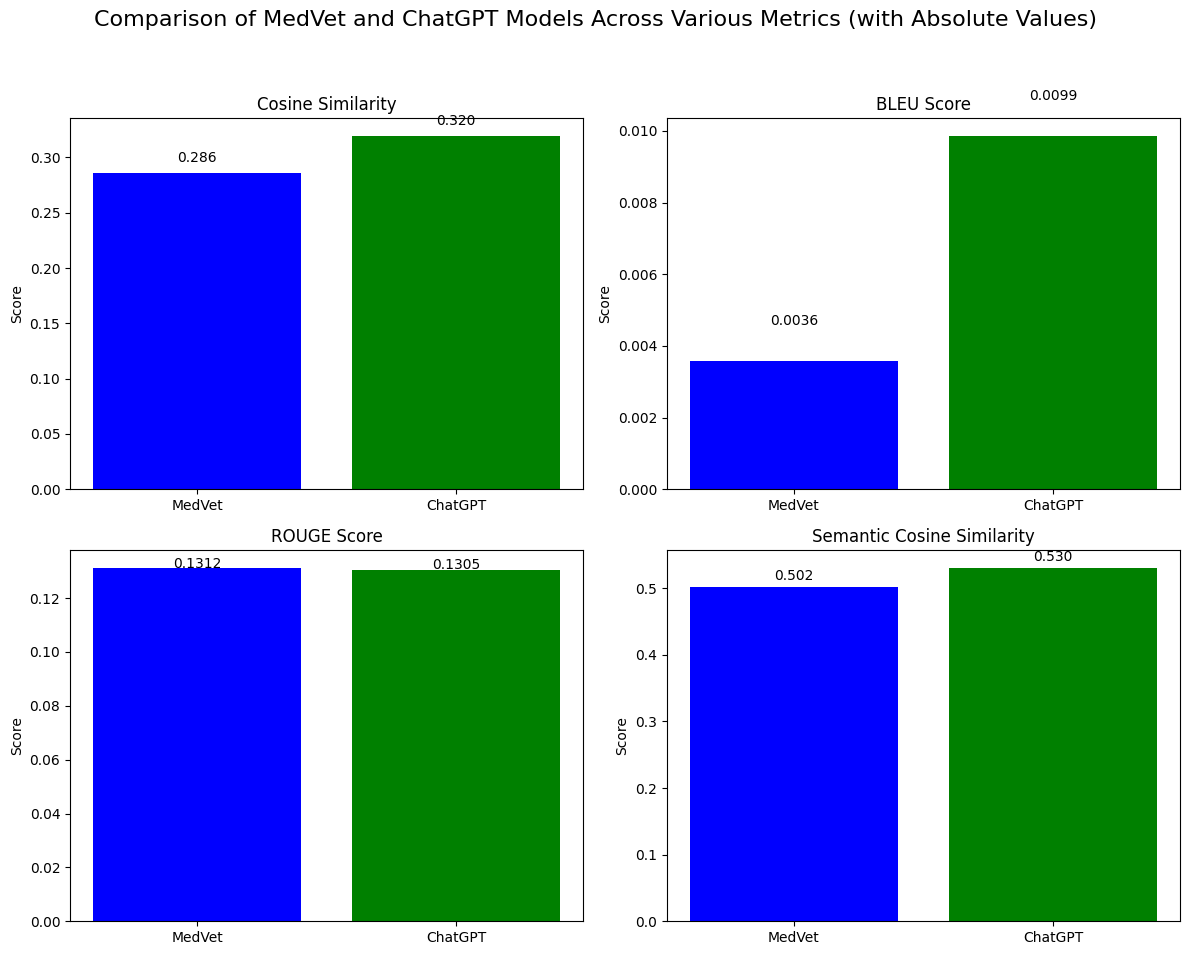

In [21]:
import matplotlib.pyplot as plt

# Data preparation for plotting
models = ['MedVet', 'ChatGPT']
cosine_similarity_scores = [average_scores_medvet['cosine_similarity_medvet'], average_scores_chatgpt['cosine_similarity_chatgpt']]
bleu_scores = [average_scores_medvet['BLEU_score'], average_scores_chatgpt['BLEU_score_gpt']]
rouge_scores = [average_scores_medvet['rouge_score_medvet'], average_scores_chatgpt['rouge_score_chatgpt']]
semantic_cosine_scores = [average_scores_medvet['semantic_cosine_similarity_medvet'], average_scores_chatgpt['semantic_cosine_similarity_chatgpt']]


# Plotting with absolute values displayed on bars
fig, axs = plt.subplots(2, 2, figsize=(12, 10))
fig.suptitle('Comparison of MedVet and ChatGPT Models Across Various Metrics (with Absolute Values)', fontsize=16)

# Cosine Similarity
axs[0, 0].bar(models, cosine_similarity_scores, color=['blue', 'green'])
axs[0, 0].set_title('Cosine Similarity')
axs[0, 0].set_ylabel('Score')
for i, v in enumerate(cosine_similarity_scores):
    axs[0, 0].text(i, v + 0.01, f"{v:.3f}", ha='center', color='black')

# BLEU Score
axs[0, 1].bar(models, bleu_scores, color=['blue', 'green'])
axs[0, 1].set_title('BLEU Score')
axs[0, 1].set_ylabel('Score')
for i, v in enumerate(bleu_scores):
    axs[0, 1].text(i, v + 0.001, f"{v:.4f}", ha='center', color='black')

# ROUGE Score
axs[1, 0].bar(models, rouge_scores, color=['blue', 'green'])
axs[1, 0].set_title('ROUGE Score')
axs[1, 0].set_ylabel('Score')
for i, v in enumerate(rouge_scores):
    axs[1, 0].text(i, v + 0.0001, f"{v:.4f}", ha='center', color='black')

# Semantic Cosine Similarity
axs[1, 1].bar(models, semantic_cosine_scores, color=['blue', 'green'])
axs[1, 1].set_title('Semantic Cosine Similarity')
axs[1, 1].set_ylabel('Score')
for i, v in enumerate(semantic_cosine_scores):
    axs[1, 1].text(i, v + 0.01, f"{v:.3f}", ha='center', color='black')

# Layout adjustment
plt.tight_layout(rect=[0, 0.03, 1, 0.95])

# Show plot with values
plt.show()



# Evaluation
**MedVet Model**
* Average Cosine Similarity: 0.286
* Average BLEU Score: 0.0036
* Average ROUGE Score: 0.131
* Average Semantic Cosine Similarity: 0.502


**ChatGPT Model**
* Average Cosine Similarity: 0.320
* Average BLEU Score: 0.0099
* Average ROUGE Score: 0.131
* Average Semantic Cosine Similarity: 0.530

Based on these averages, the ChatGPT model generally performed better than the MedVet model in terms of:

* Higher cosine similarity scores (suggesting better overall textual alignment with reference texts).
* Higher BLEU scores (indicating better precision in terms of predicted words matching the reference texts).
* Similar ROUGE scores to MedVet (indicating comparable recall abilities).
* Higher semantic cosine similarity scores (implying better capture of semantic meanings in responses).

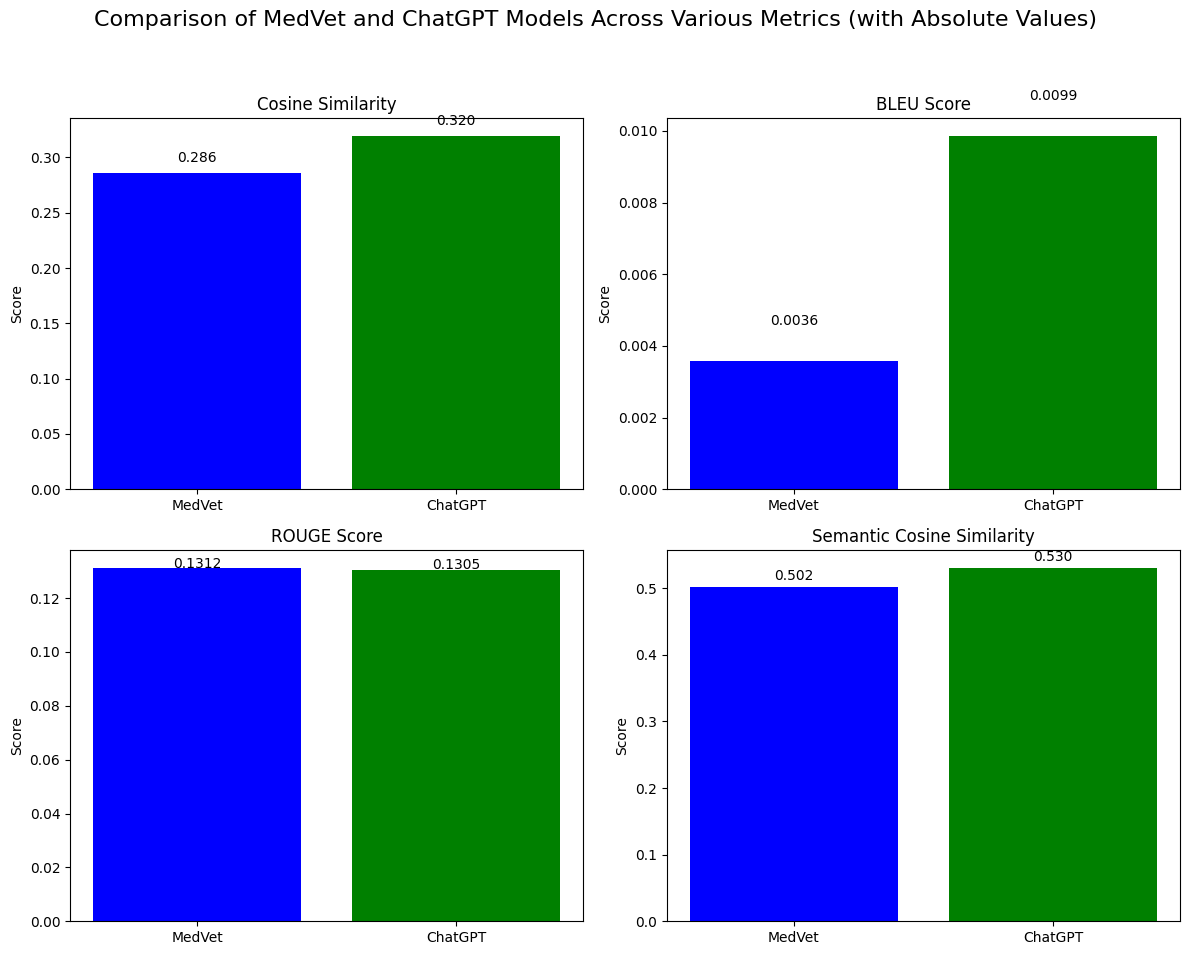
